In [1]:
import math
import numpy as np
import pandas as pd
from fun_utils import *
from scipy.optimize import minimize, least_squares
from scipy.optimize import fsolve
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
## scenario switch
case=3;  # 2 means no trade in goods; 3 means trade in both energy and goods
logit = 0; # 1 means logit estimations of supply elasticity; 0 means fixed elasticities at 0.5

In [20]:
## parameter values
alpha = 0.85;           # labor share parameter in manufacturing
theta = 4;              # scopevec for comparative advantage
sigma = 1;      # elasticity of demand for each individual manufactured good j at Home
sigmastar = 1;  # elasticity of demand for each individual manufactured good j at Foreign
epsilonD = alpha + (1 - alpha) * sigma;  #Home's elasticity of demand for embodied energy
epsilonDstar = alpha + (1 - alpha) * sigmastar;  #Foreign's elasticity of demand for embodied energy
# beta = 2.274853;
# gamma= 0.784877595;
beta=1.892412;
gamma=0.807998928;
epsilonS = 0.5;  #Homes's energy supply elasticity: beta/(1 - beta)
epsilonSstar = 0.5;  #Foreign's energy supply elasticity: betastar/(1 - betastar)
epsilonSstar1 = 0.5
epsilonSstar2 = 0.7
epsilonS1 = 0.5
epsilonS2 = 0.7

In [21]:
ParaList = (alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS, epsilonSstar1, epsilonSstar2, epsilonS1, epsilonS2, beta, gamma, logit)

In [31]:
tax_scenario= {'tax_sce': 'Unilateral', 'Base': 0}
df = {'Qe1': 2.4800448, 'Qe2': 2, 'Qestar1': 23, 'Qestar2': 4.795946, 'Qeworld': 32.27599, 'CeHH': 4.598403, 'CeHF': 1.196111,'CeFH': 0.42160103,'CeFF': 26.059874,'Ce': 5.7945137,'Cestar': 26.481474,'Ge': 5.0200038,'Gestar': 27.255985,'Ceworld': 32.27599,'Geworld': 32.27599,'jxbar': 0.015920602214279298,'jmbar':  0.7935787194577492}

In [32]:
## computes j values
def jbar_hat(pe, alpha, theta, tb_mat, df):
    jxbar_hat = (pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) / 
                 (df['jxbar'] * pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) + 
                  (1-df['jxbar']) * (pe + (1-alpha) * tb_mat[0])**(-theta)))
    
    j0_hat = (pe+tb_mat[0])**(-(1-alpha)*theta) / (df['jxbar'] * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * pe**(-(1-alpha)*theta))
    
    jmbar_hat = 1
    
    ## compute final values for j's
    jxbar_prime = jxbar_hat * df['jxbar']
    jmbar_prime = jmbar_hat * df['jmbar']
    j0_prime = j0_hat * df['jxbar']
    
    return (jxbar_hat, j0_hat, jmbar_hat, jxbar_prime, jmbar_prime, j0_prime)

def integrand(i, theta, sigmastar):
    return (i ** ((1 + theta) / theta - 1) * (1 - i) ** ((theta - sigmastar) / theta - 1)) 

def incomp_beta(low, hi, theta, sigmastar):
    return quad(integrand,low, hi, args=(theta, sigmastar))[0]

## computes extraction values (home, foreign)
def compute_qe(tb_mat, petbte, epsilonSstar1, epsilonSstar2, logit, beta, gamma, pe, epsilonS1, epsilonS2, df):
    
    Qe1_prime = df['Qe1'] * (petbte)**epsilonS1
    Qe2_prime = df['Qe2'] * (pe + tb_mat[0]) ** epsilonS2

    Qe_prime =  Qe1_prime + Qe2_prime
    
    Qe1star_prime = df['Qestar1'] * pe**epsilonSstar1
    Qe2star_prime = df['Qestar2'] * pe**epsilonSstar2
    
    Qestar_prime = Qe1star_prime + Qe2star_prime 
    
    return (Qe_prime, Qestar_prime)

## computes consumption values (home, import, export, foreign)
def compute_ce(pe, tb_mat, epsilonD,j0_hat, j0_prime, jmbar_hat, jxbar_prime, alpha, sigma, theta, epsilonDstar, df):
    
    ## home produce for home use
    CeHH_hat = (pe + tb_mat[0]) ** (-epsilonD) * jmbar_hat ** (1 + (1 - sigma)/theta)
    CeHH_prime = df['CeHH'] * CeHH_hat
    
    ## compute incomplete beta values
    Bfunvec1_prime = incomp_beta(0, j0_prime, theta, sigmastar)
    Bfunvec2_prime = incomp_beta(0, jxbar_prime, theta, sigmastar)
    
    CeFH1_hat = (pe +tb_mat[0])**(-epsilonDstar) * j0_hat**(1 + (1 - sigmastar)/theta)
    CeFH2_hat = ((1 + (1 - sigmastar)/theta) * 
                 ((1-df['jxbar'])/df['jxbar'])**(sigmastar/theta) * 
                 pe**(-epsilonDstar) * (1 + tb_mat[0]/pe)**(-alpha) * 
                 (Bfunvec2_prime - Bfunvec1_prime) /
                 df['jxbar']**(1+(1-sigmastar)/theta))
    
    CeFH1_prime = df['CeFH'] * CeFH1_hat
    CeFH2_prime = df['CeFH'] * CeFH2_hat
    CeFH_hat = CeFH1_hat + CeFH2_hat
    
    if np.isnan(CeFH_hat):
        CeFH_hat=0
        
    CeFH_prime =df['CeFH'] * CeFH_hat
    
    CeHF_hat = (pe + tb_mat[0]) ** (-epsilonD)
    CeHF_prime = df['CeHF'] * CeHF_hat
    
    CeFF_prime = df['CeFF'] * ((1 - jxbar_prime)/(1-df['jxbar'])) ** (1 + (1 - sigmastar)/theta) * pe ** (-epsilonDstar)
    
    return (CeHH_prime, CeFH1_prime, CeFH2_prime, CeFH_prime, CeHF_prime, CeFF_prime)
    

def compute_vg(df, pe, alpha, sigmastar, theta, epsilonDstar, jxbar_prime, j0_prime):
    VgFH = df['CeFH'] /(1 - alpha)
    VgFH2_hat = (pe**(1 - epsilonDstar) * ((1-j0_prime)**(1+(1-sigmastar)/theta) - (1-jxbar_prime)**(1+(1-sigmastar)/theta)) / 
                 (df['jxbar']  * (1 - df['jxbar'] )**( (1-sigmastar)/theta)))
    VgFH2_prime = VgFH * VgFH2_hat
    
    return VgFH2_prime

In [33]:
## Comsumes:
## p (a vector of price and tax), varphi (social cost of carbon), tax_scenario,
## ParaList (a list of params for tuning the model) and df

## Returns:
## the sum of absolute value differences of total extraction - consumption
## and the difference between tb (border adjustment) and it's equilibrium condition in paper.
def opt_price(p, varphi, tax_scenario, ParaList, df):
    pe = p[0]
    tb_mat = p[1:]
    alpha, theta, sigma, sigmastar, epsilonD,epsilonDstar, epsilonS, epsilonSstar1, epsilonSstar2, epsilonS1, epsilonS2, beta, gamma, logit = ParaList
    
    epsilonSstar = (epsilonSstar1 * df['Qestar1'] * pe**epsilonSstar1 + epsilonSstar2 * df['Qestar2'] * pe**epsilonSstar2) / (df['Qestar1'] + df['Qestar2'])
    epsilonSstartilde = epsilonSstar1
    
    if tax_scenario['tax_sce']!='Unilateral':
        print("shouldn't be here")
        return 0

        
    ## compute jbar_hat and jbar_prime values
    jxbar_hat, j0_hat, jmbar_hat, jxbar_prime, jmbar_prime, j0_prime = jbar_hat(pe, alpha, theta, tb_mat, df)
    

    #if te is too large, Home stop producing
    petbte = pe + tb_mat[0] - varphi
    if (petbte < 0):
        petbte = 0

    ## compute equilibrium energy extraction
    Qe_prime, Qestar_prime = compute_qe(tb_mat, petbte, epsilonSstar1, epsilonSstar2, logit, beta, gamma, pe, epsilonS1, epsilonS2, df)

    ## compute equilibrium energy consumption
    CeHH_prime, CeFH1_prime, CeFH2_prime, CeFH_prime, CeHF_prime, CeFF_prime = compute_ce(pe, tb_mat, epsilonD,j0_hat, j0_prime, jmbar_hat, jxbar_prime, alpha, sigma, theta, epsilonDstar, df)
    
    ## compute one term of value of exports (I think)
    VgFH2_prime = compute_vg(df, pe, alpha, sigmastar, theta, epsilonDstar, jxbar_prime, j0_prime)
    
    ## compute difference of extraction and consumption
    diff = Qe_prime + Qestar_prime - (CeHH_prime + CeFH_prime + CeHF_prime + CeFF_prime)
    
    ## compute second equilibrium condition
    pai_g = (pe + tb_mat[0]) * CeFH2_prime / (1 - alpha) - VgFH2_prime
    numerator = varphi * epsilonSstartilde * Qestar_prime - sigmastar * (1-alpha) * pai_g
    denominator = epsilonSstar * Qestar_prime + epsilonDstar * CeFF_prime
    diff1 = tb_mat[0] * denominator - numerator
        
    return abs(diff) + abs(diff1)

In [34]:
def comp_qe(pe, tb, varphi, epsilonSstar1, epsilonSstar2, epsilonS1, epsilonS2, df):
    petbte = pe + tb - varphi
    if (petbte < 0):
        petbte = 0
        
    Qe1_prime = df['Qe1'] * (petbte)**epsilonS1
    Qe2_prime = df['Qe2'] * (pe + tb) ** epsilonS2

    Qe_prime =  Qe1_prime + Qe2_prime
    
    Qe1star_prime = df['Qestar1'] * pe**epsilonSstar1
    Qe2star_prime = df['Qestar2'] * pe**epsilonSstar2
    
    Qestar_prime = Qe1star_prime + Qe2star_prime 
    
    return (Qe1_prime, Qe2_prime, Qe1star_prime, Qe2star_prime)
    

In [26]:
comp_qe(1,0, 0, epsilonSstar1, epsilonSstar2, epsilonS1, epsilonS2, df)

(2.4800448, 2.0, 3.0, 24.795946)

In [8]:
varphi = 27.3

In [9]:
res1 = minimize(opt_price, (1, 10), args = (varphi, tax_scenario, ParaList, df), bounds = [(0,np.inf), (0, np.inf)], method = 'Nelder-Mead', options = {'maxfev': 10000})
res1

 final_simplex: (array([[0.76917716, 7.22589089],
       [0.76918516, 7.22596806],
       [0.76918068, 7.2259365 ]]), array([0.00034605, 0.00039724, 0.00044486]))
           fun: 0.00034605410797539093
       message: 'Optimization terminated successfully.'
          nfev: 102
           nit: 56
        status: 0
       success: True
             x: array([0.76917716, 7.22589089])

In [10]:
res1 = minimize(opt_price, (1, 10), args = (varphi, tax_scenario, ParaList, df), bounds = [(0,np.inf), (0, np.inf)], method = 'Nelder-Mead', options = {'maxfev': 10000})
res1

 final_simplex: (array([[0.90779309, 9.30731009],
       [0.90779039, 9.30728004],
       [0.90779116, 9.30729718]]), array([0.00015461, 0.00016399, 0.00018527]))
           fun: 0.00015461206924172188
       message: 'Optimization terminated successfully.'
          nfev: 108
           nit: 57
        status: 0
       success: True
             x: array([0.90779309, 9.30731009])

In [39]:
res1.fun

8.433563905896335e-05

In [46]:
results = []
for varphi in range(1000):
    res1 = minimize(opt_price, (0.5, 10), args = (varphi, tax_scenario, ParaList, df), bounds = [(0,np.inf), (0, np.inf)], method = 'Nelder-Mead', options = {'maxfev': 10000})
    if res1.fun > 0.1:
        print('did not converge', varphi)
    else:
        results.append((varphi, res1.x[0], res1.x[1], comp_qe(res1.x[0], res1.x[1], varphi, epsilonSstar1, epsilonSstar2, epsilonS1, epsilonS2, df)))

did not converge 46
did not converge 47
did not converge 48
did not converge 49
did not converge 50
did not converge 51
did not converge 52


C:\Users\Alex\AppData\Local\Temp/ipykernel_12272/1416722530.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  jxbar_hat = (pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) /
C:\Users\Alex\AppData\Local\Temp/ipykernel_12272/1416722530.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  (df['jxbar'] * pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) +
C:\Users\Alex\AppData\Local\Temp/ipykernel_12272/1416722530.py:3: RuntimeWarning: invalid value encountered in double_scalars
  jxbar_hat = (pe**(-alpha*theta) * (pe+tb_mat[0])**(-(1-alpha)*theta) /
C:\Users\Alex\AppData\Local\Temp/ipykernel_12272/1416722530.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  j0_hat = (pe+tb_mat[0])**(-(1-alpha)*theta) / (df['jxbar'] * (pe+tb_mat[0])**(-(1-alpha)*theta) + (1-df['jxbar']) * pe**(-(1-alpha)*theta))
C:\Users\Alex\AppData\Local\Temp/ipykernel_12272/1416722530.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  

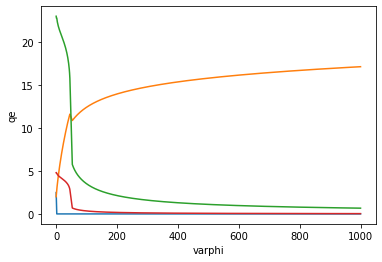

In [47]:
x_val = [x[0] for x in results]
#y_val = [x[1] for x in data]
z_val = [x[3] for x in results]
#plt.set_ylim(0, 2)
plt.xlabel('varphi')
plt.ylabel('qe')
plt.plot(x_val,z_val)
plt.savefig('../plots/renewable/phi_qe.pdf', format='PDF')

In [51]:
results[888]

(895,
 0.0009935840606822763,
 21.121054830271007,
 (0.0, 16.917851918967724, 0.7249868744335474, 0.03792429495184734))

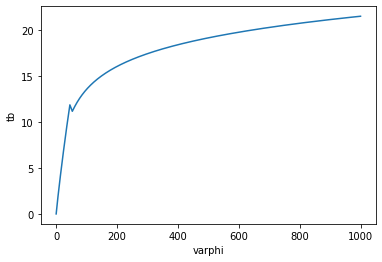

In [48]:
x_val = [x[0] for x in results]
#y_val = [x[1] for x in data]
z_val = [x[2] for x in results]
#plt.set_ylim(0, 2)
plt.xlabel('varphi')
plt.ylabel('tb')
plt.plot(x_val,z_val)
plt.savefig('../plots/renewable/phi_tb.pdf', format='PDF')

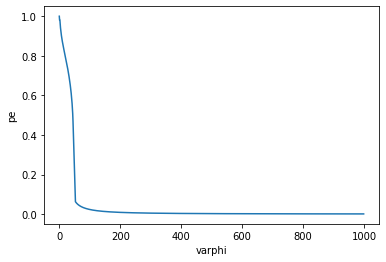

In [49]:
x_val = [x[0] for x in results]
#y_val = [x[1] for x in data]
z_val = [x[1] for x in results]
#plt.set_ylim(0, 2)
plt.xlabel('varphi')
plt.ylabel('pe')
plt.plot(x_val,z_val)
plt.savefig('../plots/renewable/phi_pe.pdf', format='PDF')